Loading full dataset from loan_data.csv.
Dataset shape: (248169, 13)
Columns: ['id', 'annual_income', 'debt_to_income_ratio', 'credit_score', 'loan_amount', 'interest_rate', 'gender', 'marital_status', 'education_level', 'employment_status', 'loan_purpose', 'grade_subgrade', 'loan_paid_back']

First 3 rows:
   id  annual_income  debt_to_income_ratio  credit_score  loan_amount  \
0   0       29367.99                 0.084           736      2528.42   
1   1       22108.02                 0.166           636      4593.10   
2   2       49566.20                 0.097           694     17005.15   

   interest_rate  gender marital_status education_level employment_status  \
0          13.67  Female         Single     High School     Self-employed   
1          12.92    Male        Married        Master's          Employed   
2           9.76    Male         Single     High School          Employed   

         loan_purpose grade_subgrade  loan_paid_back  
0               Other             

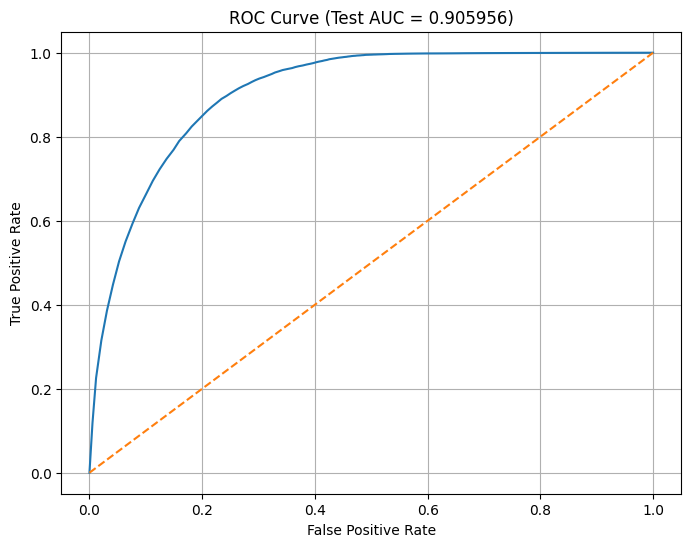


AUC by education_level (sorted):
      group  n_samples      AUC
      Other       2719 0.910103
 Bachelor's      29302 0.907522
   Master's       9718 0.904901
High School      19135 0.903689
        PhD       1168 0.897756

Overall loan_purpose AUC (sorted):
             group  n_samples      AUC
         Education       3781 0.913179
          Vacation        880 0.913132
             Other       6689 0.910432
          Business       3615 0.909221
              Home       4658 0.907342
           Medical       2392 0.905606
Debt consolidation      33898 0.904179
               Car       6129 0.903156

Top 3 performing loan_purposes (by AUC):
    group  n_samples      AUC
Education       3781 0.913179
 Vacation        880 0.913132
    Other       6689 0.910432

Bottom 3 performing loan_purposes (by AUC):
             group  n_samples      AUC
           Medical       2392 0.905606
Debt consolidation      33898 0.904179
               Car       6129 0.903156

Saved subgroup AUC tabl

In [3]:


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve, auc
import warnings
warnings.filterwarnings("ignore")

DATA_PATH = "loan_data.csv"
TARGET = "loan_paid_back"
USE_SAMPLE = False
SAMPLE_ROWS = 50000
RANDOM_STATE = 42

if USE_SAMPLE:
    print(f"Loading first {SAMPLE_ROWS} rows from {DATA_PATH} (sampling mode).")
    df = pd.read_csv(DATA_PATH, nrows=SAMPLE_ROWS)
else:
    print(f"Loading full dataset from {DATA_PATH}.")
    df = pd.read_csv(DATA_PATH)

print("Dataset shape:", df.shape)
print("Columns:", df.columns.tolist())
print("\nFirst 3 rows:")
print(df.head(3))

if TARGET not in df.columns:
    raise ValueError(f"Target column '{TARGET}' not found. Columns: {df.columns.tolist()}")

initial_rows = df.shape[0]
df.dropna(subset=[TARGET], inplace=True)
if df.shape[0] < initial_rows:
    print(f"\nDropped {initial_rows - df.shape[0]} rows with NaN values in the target column '{TARGET}'.")

print("\nTarget distribution (counts):")
print(df[TARGET].value_counts())
print("\nTarget distribution (proportions):")
print(df[TARGET].value_counts(normalize=True))

if 'id' in df.columns:
    df = df.drop(columns=['id'])

num_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
num_cols = [c for c in num_cols if c != TARGET]
cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()

print("\nNumerical columns:", num_cols)
print("Categorical columns:", cat_cols)

X = df.drop(columns=[TARGET])
y = df[TARGET]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=RANDOM_STATE, stratify=y
)

print("\nTrain shape:", X_train.shape, "Test shape:", X_test.shape)


num_imputer = SimpleImputer(strategy='median')
scaler = StandardScaler()

X_train_num = num_imputer.fit_transform(X_train[num_cols])
X_train_num = scaler.fit_transform(X_train_num)

X_test_num = num_imputer.transform(X_test[num_cols])
X_test_num = scaler.transform(X_test_num)

X_train_cat = X_train[cat_cols].copy()
X_test_cat = X_test[cat_cols].copy()

for col in cat_cols:
    freq = X_train_cat[col].fillna('MISSING').value_counts(normalize=True)
    X_train_cat[col] = X_train_cat[col].fillna('MISSING').map(freq)
    X_test_cat[col] = X_test_cat[col].fillna('MISSING').map(freq).fillna(0.0)

X_train_proc = np.hstack([X_train_num, X_train_cat.values.astype(float)])
X_test_proc = np.hstack([X_test_num, X_test_cat.values.astype(float)])

print("\nProcessed training shape:", X_train_proc.shape)
print("Processed test shape:", X_test_proc.shape)



clf = RandomForestClassifier(random_state=RANDOM_STATE,
                             class_weight='balanced',
                             n_estimators=100,
                             n_jobs=1)

print("\nTraining RandomForest...")
clf.fit(X_train_proc, y_train)


y_proba = clf.predict_proba(X_test_proc)[:, 1]
test_auc = roc_auc_score(y_test, y_proba)
print(f"\nTest ROC AUC: {test_auc:.6f}")

fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr)
plt.plot([0,1], [0,1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve (Test AUC = {roc_auc:.6f})')
plt.grid(True)
plt.show()

# Subgroup analysis

test_df = X_test.reset_index(drop=True).copy()
test_df[TARGET] = y_test.reset_index(drop=True)
test_df['pred_proba'] = y_proba


def subgroup_auc(df, group_col):
    rows = []
    for val in df[group_col].fillna('MISSING').unique():
        sub = df[df[group_col].fillna('MISSING') == val]
        if sub[TARGET].nunique() < 2:
            auc_val = np.nan
        else:
            auc_val = roc_auc_score(sub[TARGET], sub['pred_proba'])
        rows.append({'group': val, 'n_samples': len(sub), 'AUC': auc_val})
    res = pd.DataFrame(rows).sort_values(by='AUC', ascending=False)
    return res

edu_col = 'education_level'
if edu_col in test_df.columns:
    edu_auc_df = subgroup_auc(test_df, edu_col)
    print("\nAUC by education_level (sorted):")
    print(edu_auc_df.to_string(index=False))
else:
    print("\nColumn 'education_level' not present in data; skipping.")


purpose_col = 'loan_purpose'
if purpose_col in test_df.columns:
    purpose_auc_df = subgroup_auc(test_df, purpose_col)
    print("\nOverall loan_purpose AUC (sorted):")
    print(purpose_auc_df.to_string(index=False))
    # Top 3 and Bottom 3
    top3 = purpose_auc_df.head(3).reset_index(drop=True)
    bottom3 = purpose_auc_df.tail(3).reset_index(drop=True)
    print("\nTop 3 performing loan_purposes (by AUC):")
    print(top3.to_string(index=False))
    print("\nBottom 3 performing loan_purposes (by AUC):")
    print(bottom3.to_string(index=False))
else:
    print("\nColumn 'loan_purpose' not present in data; skipping.")

if 'edu_auc_df' in locals():
    edu_auc_df.to_csv("education_level_auc.csv", index=False)
if 'purpose_auc_df' in locals():
    purpose_auc_df.to_csv("loan_purpose_auc.csv", index=False)

print("\nSaved subgroup AUC tables (if computed) to:")
print(" - education_level_auc.csv")
print(" - loan_purpose_auc.csv")
